In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'
sns.set(style='ticks')

plt.rc('figure', figsize=(6, 3.7), dpi=100) # figure size
plt.rc('axes', labelpad=20, facecolor="#ffffff", # properties of axes
       linewidth=0.4, grid=True, labelsize=10) 
plt.rc('xtick.major', width=0.2) # major ticks where the labels are shown
plt.rc('ytick.major', width=0.2) # minor ticks where the labels are not shown
plt.rc('grid', color='#EEEEEE', linewidth=0.25)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('savefig', pad_inches=0.3, dpi=300)

In [2]:
TRAIN_FILE = '/kaggle/input/asl-signs/train.csv'

In [3]:
img = pd.read_parquet('/kaggle/input/asl-signs/train_landmark_files/16069/100015657.parquet')

In [4]:
img.shape

(57015, 7)

In [5]:
import torch.nn as nn

In [6]:
class datagen(nn.Module):
    def __init__(self):
        super(datagen, self).__init__()
        pass
    def forward(self, x):
    #n = len(x['frame'].value_counts())
    #x = torch.tensor(x.iloc[:, 4:].to_numpy())
    #x = x.contiguous().view(n, 543, -1)
        face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lefth_x = x[:,468:489,:].contiguous().view(-1, 21*3)
        pose_x = x[:,489:522,:].contiguous().view(-1, 33*3)
        righth_x = x[:,522:,:].contiguous().view(-1, 21*3)

        lefth_x = lefth_x[~torch.any(torch.isnan(lefth_x), dim=1),:]
        righth_x = righth_x[~torch.any(torch.isnan(righth_x), dim=1),:]

        x1m = torch.mean(face_x, 0)
        x2m = torch.mean(lefth_x, 0)
        x3m = torch.mean(pose_x, 0)
        x4m = torch.mean(righth_x, 0)

        x1s = torch.std(face_x, 0)
        x2s = torch.std(lefth_x, 0)
        x3s = torch.std(pose_x, 0)
        x4s = torch.std(righth_x, 0)

        xfeat = torch.cat([x1m,x2m,x3m,x4m, x1s,x2s,x3s,x4s], axis=0)
        xfeat = torch.where(torch.isnan(xfeat), torch.tensor(0.0, dtype=torch.float32), xfeat)

        return xfeat
    


In [7]:
d_gen = datagen()

In [8]:
df = pd.read_csv('/kaggle/input/asl-signs/train.csv')
df

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [9]:
df.values

array([['train_landmark_files/26734/1000035562.parquet', 26734,
        1000035562, 'blow'],
       ['train_landmark_files/28656/1000106739.parquet', 28656,
        1000106739, 'wait'],
       ['train_landmark_files/16069/100015657.parquet', 16069, 100015657,
        'cloud'],
       ...,
       ['train_landmark_files/25571/999833418.parquet', 25571, 999833418,
        'flower'],
       ['train_landmark_files/29302/999895257.parquet', 29302, 999895257,
        'room'],
       ['train_landmark_files/36257/999962374.parquet', 36257, 999962374,
        'happy']], dtype=object)

In [10]:
import json

with open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json', 'r') as f:
    data = json.load(f)

In [11]:
from tqdm import tqdm
import os
import torch

In [12]:
ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    return data.astype(np.float32)

In [13]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader


In [14]:
tr = pd.DataFrame(np.load('/kaggle/input/isrl-basic-data-mean/feature_data.npy'))
out = pd.DataFrame(np.load('/kaggle/input/isrl-basic-data-mean/feature_labels.npy'))

In [15]:
class data(Dataset):
    def __init__(self, df, label):
        self.df = df
        self.label = label
        
    def __getitem__(self, index):
        inp = torch.tensor(self.df.values[index]).float()    
        target = torch.tensor(self.label.values[index]).long()
        return inp, target
    
    def __len__(self):
        return len(self.df)

In [16]:
tr_d = data(tr, out)

In [17]:
tr_d[0]

(tensor([ 0.5277,  0.3780, -0.0373,  ...,  0.1577,  0.0730,  0.0426]),
 tensor([25]))

In [18]:
tr_ds, val_ds = random_split(tr_d, [0.80, 0.20])
tr_dl = DataLoader(tr_ds, batch_size=512, shuffle=True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=512, num_workers=8, pin_memory=True)

In [19]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
tr_dl = DeviceDataLoader(tr_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [22]:
import torch.nn as nn

In [23]:
import torch.nn.functional as F


In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, 250)
        self.dropout = nn.Dropout(dropout)
        self.loss = nn.CrossEntropyLoss()
    def forward(self, x):
        out, _ = self.lstm(x)

        # Check if the LSTM returns output for all time steps
        if out.dim() > 2:
            # Squeeze the sequence dimension
            out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

    
    def training_step(self, batch):
        inputs, targets = batch
        targets = targets.squeeze(dim=-1)
        outputs = self(inputs)
        loss = self.loss(outputs, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        targets = targets.squeeze(dim=-1)
        outputs = self(inputs)
        loss = self.loss(outputs, targets)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == targets).sum().item()
        total = targets.size(0)
        accuracy = correct / total
        return {'val_loss': loss.detach(), 'val_acc': accuracy}



    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accuracies = [x['val_acc'] for x in outputs]
        epoch_loss = torch.tensor(batch_losses).mean()   # Combine losses
        epoch_acc = torch.tensor(batch_accuracies).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))



In [26]:
model = to_device(LSTMModel(input_size=3258, hidden_size=256, output_size=250), device)
model

LSTMModel(
  (lstm): LSTM(3258, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=250, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (loss): CrossEntropyLoss()
)

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.tensor(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 5.522535800933838, 'val_acc': 0.004145331680774689}]

In [29]:
epochs = 200
max_lr = 0.006
grad_clip = 0.1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, tr_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 5.5226, val_loss: 5.5222, val_acc: 0.0045
Epoch [1], train_loss: 5.5199, val_loss: 5.5187, val_acc: 0.0042
Epoch [2], train_loss: 5.4324, val_loss: 5.1893, val_acc: 0.0160
Epoch [3], train_loss: 5.0364, val_loss: 4.8750, val_acc: 0.0235
Epoch [4], train_loss: 4.8331, val_loss: 4.7511, val_acc: 0.0401
Epoch [5], train_loss: 4.6551, val_loss: 4.4987, val_acc: 0.0649
Epoch [6], train_loss: 4.4859, val_loss: 4.3893, val_acc: 0.0742
Epoch [7], train_loss: 4.3913, val_loss: 4.2699, val_acc: 0.0905
Epoch [8], train_loss: 4.2621, val_loss: 4.0745, val_acc: 0.1189
Epoch [9], train_loss: 4.0808, val_loss: 3.8736, val_acc: 0.1492
Epoch [10], train_loss: 3.9489, val_loss: 3.8099, val_acc: 0.1566
Epoch [11], train_loss: 3.8199, val_loss: 3.6051, val_acc: 0.1849
Epoch [12], train_loss: 3.6921, val_loss: 3.4495, val_acc: 0.2187
Epoch [13], train_loss: 3.5646, val_loss: 3.3572, val_acc: 0.2231
Epoch [14], train_loss: 3.4879, val_loss: 3.3187, val_acc: 0.2351
Epoch [15], train_lo

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

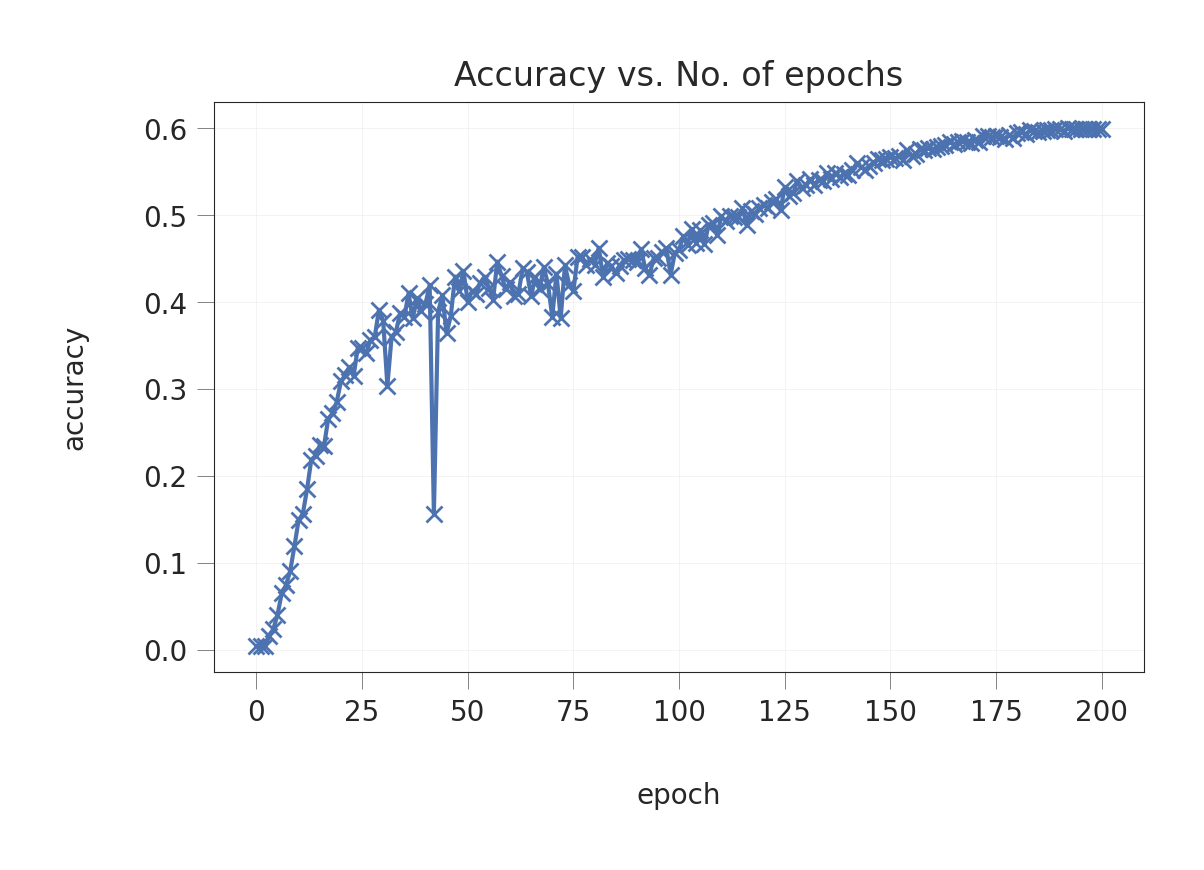

In [32]:
plot_accuracies(history)

In [33]:
!pip install onnx-tf
!pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00a 0:00:01


In [34]:
sample_input = torch.rand((50, 543, 3))
onnx_feat_gen_path = 'feature_gen.onnx'

d_gen.eval()

torch.onnx.export(
    d_gen,                  # PyTorch Model
    sample_input,                    # Input tensor
    onnx_feat_gen_path,        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'], # Output tensor name (arbitary)
    dynamic_axes={
        'input' : {0: 'input'}
    }
)

In [35]:
sample_input = torch.rand((1, 3258)).cuda()
onnx_model_path = 'asl_model.onnx'

model.eval()

torch.onnx.export(
    model,                  # PyTorch Model
    sample_input,                    # Input tensor
    onnx_model_path,        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'],   # Input tensor name (arbitary)
    output_names=['output'], # Output tensor name (arbitary)
    dynamic_axes={
        'input' : {0: 'input'}
    }
)

In [36]:
import onnx
from onnx_tf.backend import prepare


tf_feat_gen_path = '/kaggle/working/tf_feat_gen'
onnx_feat_gen = onnx.load(onnx_feat_gen_path)
tf_rep = prepare(onnx_feat_gen)
tf_rep.export_graph(tf_feat_gen_path)


tf_model_path = '/kaggle/working/tf_model'
onnx_model = onnx.load(onnx_model_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(tf_model_path)

In [37]:
import tensorflow as tf

class ASLInferModel(tf.Module):
    def __init__(self):
        super(ASLInferModel, self).__init__()
        self.feature_gen = tf.saved_model.load(tf_feat_gen_path)
        self.model = tf.saved_model.load(tf_model_path)
        self.feature_gen.trainable = False
        self.model.trainable = False
    
    @tf.function(input_signature=[
      tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')
    ])
    def call(self, input):
        output_tensors = {}
        features = self.feature_gen(**{'input': input})['output']
        output_tensors['outputs'] = self.model(**{'input': tf.expand_dims(features, 0)})['output'][0,:]
        return output_tensors
    
    
mytfmodel = ASLInferModel()
tf.saved_model.save(mytfmodel, '/kaggle/working/tf_infer_model', signatures={'serving_default': mytfmodel.call})